# FEM from scratch: Laplace problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We implement the $\mathbb{P}^1$ FEM for solving the Laplace problem with Dirichlet and Neumann boundary conditions. On the unit square $\Omega = {[0,1]}^2$ we consider 
\begin{equation*}
  \begin{cases}
    -\Delta u = f, \qquad & \text{in }\Omega, \\
    u = g_D, \qquad & \text{on }\Gamma_D, \\
    \boldsymbol{\nabla}{u}\cdot\boldsymbol{n} = g_N & \text{on }\Gamma_N.
  \end{cases}
\end{equation*}

We test the solver using the simple analytical solution given by 
$$
u(x,y) = (1-x^2)(1-y^2),
$$
from which we infer $f = 4 - 2(x^2+y^2)$. .
We consider three different configurations of boundary conditions:

1.   **Problem 1**: full Dirichlet conditions, i.e.  $\Gamma_D = \partial\Omega$
2.   **Problem 2**: mixed homogeneous conditions, i.e. $\Gamma_D := \{ (x,y)\in\partial\Omega\ | x=1 \} \cup \{ (x,y)\in\partial\Omega\ | y=1 \}$ and $\Gamma_N :=\partial\Omega\setminus\Gamma_D$ (which, indeed, yields $g_D=0$ and $g_N=0$). 
3.   **Problem 3**: mixed non-homogeneous conditions, i.e.
$\Gamma_D := \{ (x,y)\in\partial\Omega\ | x=0 \} \cup \{ (x,y)\in\partial\Omega\ | x=1 \}$ and $\Gamma_N :=\partial\Omega\setminus\Gamma_D$. 



### Step 1: Mesh generation and reordering of boundary nodes

In [2]:
def left_mesh(a, b, nx, ny):
  '''
  construct a left-type uniform triangular mesh of [0,a] x [0,b] starting from a 
  cartesian grid with nx cells in the x-direction and ny cells in the y-direction
  '''
  P = np.zeros(((nx+1)*(ny+1),2))
  T = np.zeros((2*nx*ny,3), dtype=np.int)

  x = np.linspace(0, a, nx+1)
  y = np.linspace(0, b, ny+1)

  for i in range(0, nx+1):
      for j in range(0, ny+1):
          # create node matrix P (ordered from bottom-left to top-right)
          P[i*(ny+1)+j,0] = x[i]
          P[i*(ny+1)+j,1] = y[j]

          # create correspondence matrix T with local backward orientation
          if (i<nx) & (j<ny):
              T[2*(i*ny+j),0] = i*(ny+1) + j
              T[2*(i*ny+j),1] = (i+1)*(ny+1) + j
              T[2*(i*ny+j),2] = i*(ny+1) + j+1
              
              T[2*(i*ny+j)+1,0] = i*(ny+1) + j+1
              T[2*(i*ny+j)+1,1] = (i+1)*(ny+1) + j
              T[2*(i*ny+j)+1,2] = (i+1)*(ny+1) + j+1

  return P, T

In [3]:
def Dirichlet(a, b, Point, tol, pb = 0):
  '''
  condition defining the Dirichlet boundary
  '''
  edge_0 = Point[0] < tol
  edge_1 = Point[1] < tol 
  edge_2 = Point[0] > a-tol
  edge_3 = Point[1] > b-tol
  
  if pb == 0:    # full Dirichlet problem
    diric_bc = (edge_0 or edge_1) or (edge_2 or edge_3)
  elif pb == 1:  # mixed homogeneous problem
    diric_bc = edge_2 or edge_3
  elif pb == 2:  # mixed non-homogeneous problem
    diric_bc = edge_0 or edge_2
  else:
    print('wrong pb argument:') 
    print('  0= full Dirichelt, 1= mixed homogeneous, 2= mixed non-homogeneous')

  return diric_bc

In [4]:
def Neumann(a, b, Point, tol, pb = 0):
  '''
  condition defining the Neumann boundary
  '''
  edge_0 = Point[0] < tol
  edge_1 = Point[1] < tol 
  edge_2 = Point[0] > a-tol
  edge_3 = Point[1] > b-tol

  if pb == 0:    # full Dirichlet problem
    neuma_bc = False
  elif pb == 1:  # mixed homogeneous problem
    neuma_bc = edge_0 or edge_1
  elif pb == 2:  # mixed non-homogeneous problem
    neuma_bc = edge_1 or edge_3
  else:
    print('wrong pb argument:') 
    print('  0= full Dirichelt, 1= mixed homogeneous, 2= mixed non-homogeneous')

  return neuma_bc

In [5]:
def ordered_mesh(a, b, nx, ny, pb = 0):
  '''
  construct a left-type uniform triangular mesh of [0,a] x [0,b] starting from a 
  cartesian grid with nx cells in the x-direction and ny cells in the y-direction
  P,T are modified in order to put internal nodes first and Dirichlet nodes last
  '''
  P, T = left_mesh(a, b, nx, ny)
  P_new = np.zeros(P.shape)
  T_new = np.zeros(T.shape, dtype = int)
  
  n_bndry = 2 * (nx + ny) 
  n_inter = 0
  n_diric = 0
  n_neumn = 0

  tol = min(a/(2*nx), b/(2*ny))
  v = np.zeros(P[:,0].size, dtype = int)     # permutation map

  for i in range(P[:,0].size):

    if Dirichlet(a, b, P[i,:], tol, pb):
      # node i belongs to Dirichlet boundary
      v[i] = P[:,0].size - n_diric - 1
      n_diric += 1
    elif Neumann(a, b, P[i,:], tol, pb):
      # node i belongs to Neumann boundary
      v[i] = P[:,0].size - n_bndry + n_neumn 
      n_neumn += 1
    else: 
      # node i is internal 
      v[i] = n_inter
      n_inter += 1
    
    # update nodes matrix P 
    P_new[v[i],:] = P[i,:]

  # update elements matrix T
  T_new[:,:] = v[T[:,:]]

  return P_new, T_new, n_diric, n_neumn

In [6]:
def plot_mesh(P, E):
  for i in range(E[:,0].size):
    x = [P[E[i, E[0,:].size-1], 0], P[E[i, 0], 0]]
    y = [P[E[i, E[0,:].size-1], 1], P[E[i, 0], 1]]
    plt.plot(x, y, "k")
    for j in range(E[0,:].size-1):
      x = [P[E[i, j], 0], P[E[i, j+1], 0]]
      y = [P[E[i, j], 1], P[E[i, j+1], 1]]
      plt.plot(x, y, "k")
        
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


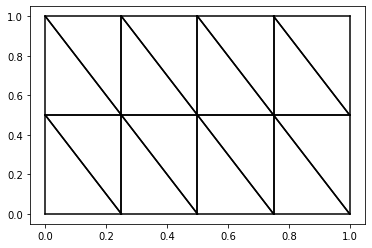

[[0.25 0.5 ]
 [0.5  0.5 ]
 [0.75 0.5 ]
 [0.25 0.  ]
 [0.25 1.  ]
 [0.5  0.  ]
 [0.5  1.  ]
 [0.75 0.  ]
 [0.75 1.  ]
 [1.   1.  ]
 [1.   0.5 ]
 [1.   0.  ]
 [0.   1.  ]
 [0.   0.5 ]
 [0.   0.  ]]


In [7]:
P, T, n_diric, n_neumn = ordered_mesh(1, 1, 4, 2, 2)
plot_mesh(P,T)
print(P)

### Assembling of stiffness matrix and right-hand side

Let $\phi_i$ be the hat-function associated to the $i$-th node in the mesh $\mathcal{T}_h$. We denote with $\mathcal{E}_h^N$ the set of boundary edges belonging to the Neumann boundary. The linear system associated to the FEM approximation reads $M \boldsymbol{u} = \boldsymbol{F}$, where

*   The stiffness matrix $M$ is given by:
$$
M_{ij} = \sum_{T\in \mathcal{T}_h}\int_T \boldsymbol{\nabla} \phi_i \cdot \boldsymbol{\nabla} \phi_j
$$
*   the right-hand side vector $\boldsymbol{F}$ is given by:
$$
F_i = \sum_{T\in \mathcal{T}_h}\int_T f\phi_i +
\sum_{E\in \mathcal{E}_h^N}\int_E g_N\phi_i - 
\sum_{P_j\in \mathcal{V}_h^D} g_D(P_j)\sum_{T\in \mathcal{T}_h}\int_T \boldsymbol{\nabla} \phi_i \cdot \boldsymbol{\nabla} \phi_j.
$$

In **problem 1** and **problem 2** the contribution to $\boldsymbol{F}$ associated to the Neumann BC vanishes. 
Moreover, we can deal with non-homogenoeous Dirichlet conditions using the usual trick. Thus, we start by focusing on the assembling of $M$ and the term corresponding to the volumetric load function. We will explain later how to take into account the BCs.

Let the nodes $P_i$ and $P_j$ belong to the boundary of element $T$ and let $e_i$ and $e_j$ be the edges of $T$ opposed to the vertices $P_i$ and $P_j$, respectively. We observe that 
$$
(\boldsymbol{\nabla}\phi_i)_{|T} = \frac{R_{\pi/2} \boldsymbol{e}_i}{2\ |T|}, \quad\text{ and }\;\;
(\boldsymbol{\nabla}\phi_i\cdot\boldsymbol{\nabla}\phi_j)_{|T} =
\frac{\boldsymbol{e}_i \cdot \boldsymbol{e}_j}{4\ |T|^2}.
$$
Thus, $\int_T \boldsymbol{\nabla}\phi_i\cdot\boldsymbol{\nabla}\phi_j = \frac{\boldsymbol{e}_i \cdot \boldsymbol{e}_j}{4\ |T|} $.
 

The term associated to the load function $\boldsymbol{f}$ is computing using a simple quadrature rule (evaluation at the center of each element).

In [8]:
def assemble(P, T, f):
  '''
  construct the Grad*Grad stiffness matrix and rhs vector 
  corresponding to mesh (P,T) and voulmetric load function f
  '''
  n_nodes = P[:,0].size
  n_elems = T[:,0].size
  M = np.zeros((n_nodes, n_nodes))
  b = np.zeros(n_nodes)

  for k in range(n_elems):
    # compute edges of element k
    e = np.zeros((3,2))
    e[2,:] = P[T[k,1],:] - P[T[k,0],:]
    e[0,:] = P[T[k,2],:] - P[T[k,1],:]
    e[1,:] = P[T[k,0],:] - P[T[k,2],:] 
    area_T = np.linalg.det(e[0:2,:])/2.0
    bar_T = np.array((P[T[k,0],:] + P[T[k,1],:] + P[T[k,2],:])/3.0)
 
    # each local contribution is stored in the corresponding global position
    for iloc in range(3):
      b[T[k,iloc]] += area_T * f(bar_T[0], bar_T[1]) / 3.0;
      for jloc in range(3):
        M[T[k,iloc], T[k,jloc]] += np.dot(e[iloc,:], e[jloc,:])/(4*area_T)

  return M, b

### Main program

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


n=20 eL2=9.43e-04 eH1=4.29e-02


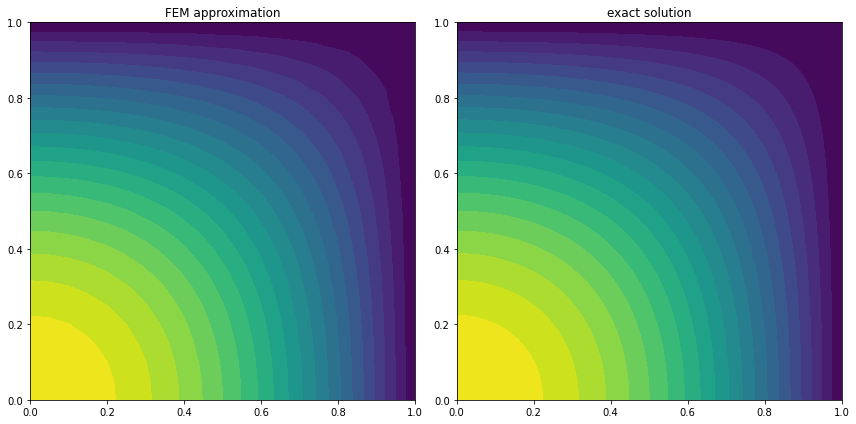

In [10]:
pb = 2
n = 20
f = lambda x, y: 4 - 2* (x**2+y**2)
u = lambda x, y: (1-x**2)*(1-y**2)
def grad_u(x,y): 
  grad = np.array([-2*x*(1-y**2), -2*y*(1-x**2)])
  return grad

# Step 1: meshing
P, T, n_diric, n_neumn = ordered_mesh(1, 1, n, n, pb)

# Step 2: definitions of discrete space (dofs)
n_nodes = P[:,0].size
n_dofs = n_nodes - n_diric
uh = np.zeros(n_nodes)

# Step 3: assembling matrices and rhs vectors
M, b = assemble(P, T, f)
# accounting for Neumann BCs
for j in range(n_dofs-n_neumn, n_dofs):
  b[j] += neumann_rhs(1, 1, P[j,:], grad_u, 1/(2*n))
# accounting for Dirichlet BCs
uh[n_dofs:n_nodes] = u(P[n_dofs:n_nodes,0], P[n_dofs:n_nodes,1])
b[0:n_dofs] += -np.dot(M[0:n_dofs, n_dofs:n_nodes], uh[n_dofs:n_nodes])

# Step 4: solving linear system
A = M[0:n_dofs, 0:n_dofs]
uh[0:n_dofs] = np.linalg.solve(A, b[0:n_dofs])

# Step 5a: compute errors
err_h1 = 0
err_l2 = 0
for k in range(T[:,0].size):
  # compute edges of element k
  e = np.zeros((3,2))
  e[2,:] = P[T[k,1],:] - P[T[k,0],:]
  e[0,:] = P[T[k,2],:] - P[T[k,1],:]
  e[1,:] = P[T[k,0],:] - P[T[k,2],:] 
  area_T = np.linalg.det(e[0:2,:])/2.0
  bar_T = np.array((P[T[k,0],:] + P[T[k,1],:] + P[T[k,2],:])/3.0)

  gradu_bar = grad_u(bar_T[0], bar_T[1])
  grad_uh = np.array([sum(-e[:,1]*uh[T[k,:]]), sum(e[:,0]*uh[T[k,:]])])/(2*area_T)
  err_h1 += area_T * np.dot(gradu_bar - grad_uh, gradu_bar - grad_uh)

  u_bar = u(bar_T[0], bar_T[1])
  uh_bar = (uh[T[k,0]] + uh[T[k,1]] + uh[T[k,2]])/3.0
  err_l2 += area_T * (uh_bar - u_bar)**2

err_h1 = np.sqrt(err_h1)
err_l2 = np.sqrt(err_l2)
print('n={} eL2={:.2e} eH1={:.2e}'.format(n, err_l2, err_h1))

# Step 5b: plot the results and compare with true solution
Q, T = left_mesh(1,1,4*n,4*n)
u_ex = u(Q[:,0], Q[:,1])
fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].tricontourf(P[:,0], P[:,1], uh , 20)
axes[0].set_title("FEM approximation");

axes[1].tricontourf(Q[:,0], Q[:,1], u_ex , 20)
axes[1].set_title("exact solution");

fig.tight_layout()
plt.show()

In [9]:
def neumann_rhs(a, b, Point, grad_u, tol):
  '''
  returns the average flux in the two Neumann edges sharing 'Point' 
  '''
  # on the domain boundary we define the outward-pointing normal vectors
  # corresponding to the two edges sharing 'Point' 
  if (Point[0] < tol) and (Point[1] < b-tol):
     normal_l = np.array([-1, 0])
     if Point[1] < tol:
       normal_r = np.array([0, -1])
     else:
       normal_r = normal_l
  elif Point[1] < tol:  
     normal_l = np.array([0, -1])
     if Point[0] > a-tol:
       normal_r = np.array([1, 0])
     else:  
       normal_r = normal_l
  elif Point[0] > a-tol: 
     normal_l = np.array([1, 0])
     if Point[1] > b-tol:
       normal_r = np.array([0, 1])
     else:
       normal_r = normal_l
  else:
     normal_l = np.array([0, 1])
     if Point[0] < tol:
       normal_r = np.array([-1, 0])
     else:
       normal_r = normal_l
  
  tangent_l = np.array([normal_l[1], -normal_l[0]]) * tol 
  tangent_r = np.array([-normal_r[1], normal_r[0]]) * tol 
  flux_l = np.dot(grad_u((Point+tangent_l)[0], (Point+tangent_l)[1]), normal_l)
  flux_r = np.dot(grad_u((Point+tangent_r)[0], (Point-tangent_r)[1]), normal_r)
  flux = tol*(flux_l + flux_r)

  return flux